In [42]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../../src/models')
from clustering import consensus_signatures

In [43]:
investigate_k = 8

In [44]:
k_index=investigate_k-1 # Assuming k is defined
S_all=[] # Assuming S_all is defined
A_all=[] # Assuming A_all is defined
err_all=[] # Assuming err_all is defined
n_iter_all=[] # Assuming n_iter_all is defined
time_start=0 # Assuming time_start is defined
time_end=1 # Assuming time_end is defined

with open('../../data/nmf_runs/01_nmf_k_selection.runs', 'rb') as f:
    results = pickle.load(f)
    
results[k_index] = {
            'S_all': S_all,
            'A_all': A_all,
            'err_all': err_all,
            'n_iter_all': n_iter_all,
            'time': time_end - time_start
        }

NMF_PARAMS = {
        'resample_method': 'poisson',
        'objective_function': 'frobenius',
        'initialization_method': 'random',
        'normalization_method': 'GMM',
        'max_iter': 1000000,
        'num_factorizations': 100,
        'random_state': 42,
        'tolerance': 1e-6
    }

In [45]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [46]:
results[investigate_k].keys()

dict_keys(['S_all', 'A_all', 'err_all', 'n_iter_all', 'time'])

In [47]:
investigate_S_all = results[investigate_k]["S_all"]
investigate_S_all.shape

(100, 96, 8)

In [48]:
df = pd.read_csv("../../data/processed/BRCA.SBS96.all", sep="\t")

# 2. Drop the "MutationType" column
feature_names = df["MutationType"].tolist()
df_matrix = df.drop(columns=["MutationType"])
sample_ids = list(df_matrix.columns)

X = df_matrix.to_numpy()
X

array([[0, 3, 0, ..., 1, 1, 0],
       [1, 3, 3, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 2, 1, ..., 2, 0, 0]], shape=(96, 789))

In [49]:
centroids_s, sil_score_s = consensus_signatures(X, investigate_S_all, k = investigate_k, average_threshold=0.8, minimum_threshold=0.2, reconstruction=False)
print(sil_score_s)

Cluster 0: avg_sil=0.960, min_sil=0.916
Cluster 1: avg_sil=0.596, min_sil=-0.737
Cluster 2: avg_sil=0.919, min_sil=0.571
Cluster 3: avg_sil=0.481, min_sil=-0.954
Cluster 4: avg_sil=0.890, min_sil=0.603
Cluster 5: avg_sil=0.911, min_sil=0.490
Cluster 6: avg_sil=0.905, min_sil=0.420
Cluster 7: avg_sil=0.969, min_sil=0.807
6 stable centroids found
0.8287140284463468


In [50]:
len(centroids_s)

6

In [51]:
# Convert the list to a NumPy array
centroids_np = np.array(centroids_s)

# Transpose the NumPy array
centroids_transposed = centroids_np.T

# Determine the number of columns after transposition
num_cols = centroids_transposed.shape[1]
print(num_cols)
# Create column names
column_names = [f"SBS96{chr(65 + i)}" for i in range(num_cols)]

# Turn the transposed NumPy array into a Pandas DataFrame
centroids_df = pd.DataFrame(centroids_transposed, index=df["MutationType"], columns=column_names)

centroids_df

6


,SBS96A,SBS96B,SBS96C,SBS96D,SBS96E,SBS96F
MutationType,,,,,,
A[C>A]A,0.003058,0.001843,0.000521,0.000126,0.018645,0.000012
A[C>A]C,0.001114,0.000217,0.000544,0.000205,0.025094,0.004049
A[C>A]G,0.003300,0.000030,0.000081,0.000014,0.007805,0.000161
A[C>A]T,0.001997,0.000216,0.000112,0.000113,0.014309,0.003164
A[C>G]A,0.000464,0.003260,0.001813,0.000156,0.017008,0.000009
...,...,...,...,...,...,...
T[T>C]T,0.011728,0.000331,0.000239,0.000652,0.006757,0.005412
T[T>G]A,0.000451,0.000287,0.000132,0.000210,0.004653,0.000038
T[T>G]C,0.000666,0.000805,0.000311,0.000119,0.004658,0.001559


In [52]:
tsv_file_path = "/Users/zichenjiang/Downloads/SBS96_arivoli/Suggested_Solution/SBS96_De-Novo_Solution/Signatures/SBS96_De-Novo_Signatures.txt"
signatures_df = pd.read_csv(tsv_file_path, sep="\t").set_index('MutationType')

def calculate_norms(df1, df2):
    common_cols = df1.columns.intersection(df2.columns)
    norms = []
    for col in common_cols:
        l1_norm = np.sum(np.abs(df1[col] - df2[col]))
        l2_norm = np.sqrt(np.sum((df1[col] - df2[col]) ** 2))
        norms.append({'Column': col, 'L1_Norm': l1_norm, 'L2_Norm': l2_norm})
    return pd.DataFrame(norms)

aligned_centroids_df = centroids_df.reindex(signatures_df.index, axis=0, method='nearest', copy=False)
aligned_signatures_df = signatures_df.reindex(aligned_centroids_df.index, axis=0, method='nearest', copy=False)
norms_result = calculate_norms(aligned_centroids_df, aligned_signatures_df)
print(norms_result)


   Column   L1_Norm   L2_Norm
0  SBS96A  1.830419  0.405196
1  SBS96B  1.748564  0.588409
2  SBS96C  1.568905  0.490158


In [53]:
def plot_centroid_column(column, df_index, title_text, output_path, cluster_sil_data):
    mutation_colors = {
        "C>A": [3 / 256, 189 / 256, 239 / 256],
        "C>G": [1 / 256, 1 / 256, 1 / 256],
        "C>T": [228 / 256, 41 / 256, 38 / 256],
        "T>A": [203 / 256, 202 / 256, 202 / 256],
        "T>C": [162 / 256, 207 / 256, 99 / 256],
        "T>G": [236 / 256, 199 / 256, 197 / 256],
    }

    mutation_types = df_index.to_list()
    substitutions = [mut.split('[')[1].split(']')[0] for mut in mutation_types]
    flanking_bases = [mut.replace(f'[{sub}]', '') for mut, sub in zip(mutation_types, substitutions)]

    ordered_indices = sorted(range(len(mutation_types)), key=lambda i: ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"].index(substitutions[i]))
    x_positions = np.arange(len(ordered_indices))
    bar_colors = [mutation_colors[substitutions[i]] for i in ordered_indices]

    fig, ax = plt.subplots(figsize=(13, 4), dpi=500)
    ax.grid(axis='y', alpha=0.5, color='lightgrey', linewidth=0.5, zorder=1)

    # Ensure y_values are ordered according to ordered_indices and convert to percentage
    # The 'column' Series is reordered using .iloc[ordered_indices] and then converted to a NumPy array with .values
    y_values_for_plot = column.iloc[ordered_indices].values * 100
    
    ax.bar(x_positions, y_values_for_plot, width=0.5, color=bar_colors, alpha=0.8, zorder=2)

    # ymax calculation should use the reordered values that are actually plotted
    # If all values in y_values_for_plot are 0, y_values_for_plot.max() will be 0, leading to ymax = 0.
    # This would cause ax.set_ylim(0, 0), which might impact subsequent calculations using ax.get_ylim().
    ymax = y_values_for_plot.max() * 1.1
    ax.set_ylim(0, ymax)

    unique_subs = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
    group_positions = {sub: [] for sub in unique_subs}
    # Correctly populate group_positions with the new x_positions (i)
    for i, original_idx in enumerate(ordered_indices):
        substitution_type = substitutions[original_idx]
        group_positions[substitution_type].append(i)

    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    for i, idx in enumerate(ordered_indices):
        flank = flanking_bases[idx]
        sub = substitutions[idx]
        # Note: If y_range is 0 (due to ymax being 0), the y-offsets for text will also be 0.
        five_prime_flank_y_pos = ax.get_ylim()[0] - (y_range/15)
        ref_y_pos = ax.get_ylim()[0] - (y_range/30)
        three_prim_flank_y_pos = ax.get_ylim()[0] - (y_range/200)
        ax.text(i, five_prime_flank_y_pos, flank[0], ha='center', va='top', rotation=90, fontsize=8, color="grey")
        ax.text(i, ref_y_pos, sub[0], ha='center', va='top', rotation=90, fontsize=8, color=mutation_colors[sub], fontweight='bold')
        ax.text(i, three_prim_flank_y_pos, flank[1], ha='center', va='top', rotation=90, fontsize=8, color="grey", clip_on=False)

    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xlim(-0.5, len(mutation_types) - 0.5)
    ax.set_xticks([])
    ax.set_ylabel("Percentage of Single Base Substitutions", fontsize=9)

    ax.spines['top'].set_color("lightgrey")
    ax.spines['right'].set_color("lightgrey")
    ax.spines['left'].set_color("lightgrey")
    ax.spines['bottom'].set_color("lightgrey")

    ax.tick_params(axis='y', colors='grey', width=0.5)
    plt.yticks(fontsize=8)
    ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])

    for sub_key in unique_subs:
        if group_positions[sub_key]: # Ensure the list of positions is not empty
            min_x, max_x = min(group_positions[sub_key]), max(group_positions[sub_key])
            rect_color = mutation_colors[sub_key]
            # Note: If ax.get_ylim()[1] (i.e., ymax) is 0, rectangle y-position and height will be 0.
            ax.add_patch(plt.Rectangle((min_x, ax.get_ylim()[1] * 1.03), max_x - min_x, ax.get_ylim()[1]* 0.05,
                                color=rect_color, clip_on=False))
            ax.text((min_x + max_x) / 2, ax.get_ylim()[1] * 1.1, sub_key, ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.text(0.01, 0.95, title_text, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    cluster_letter = title_text.replace("SBS96", "")
    cluster_index = ord(cluster_letter) - ord('A')
    cluster_info = cluster_sil_data[cluster_index]
    ax.text(0.99, 0.95, f"avg silouette={cluster_info['avg_sil']:.3f}, min silouette={cluster_info['min_sil']:.3f}",
            transform=ax.transAxes, fontsize=10, va='top', ha='right')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()


In [ ]:
# import re

# text_data = """Cluster 0: avg_sil=0.960, min_sil=0.916
# Cluster 1: avg_sil=0.596, min_sil=-0.737
# Cluster 2: avg_sil=0.919, min_sil=0.571
# Cluster 3: avg_sil=0.481, min_sil=-0.954
# Cluster 4: avg_sil=0.890, min_sil=0.603
# Cluster 5: avg_sil=0.911, min_sil=0.490
# Cluster 6: avg_sil=0.905, min_sil=0.420
# Cluster 7: avg_sil=0.969, min_sil=0.807"""

# cluster_sil_data = {}
# pattern = re.compile(r"Cluster (\d+): avg_sil=([-\d.]+), min_sil=([-\d.]+)")

# for line in text_data.strip().split('\n'):
#     match = pattern.match(line)
#     if match:
#         cluster_id = int(match.group(1))
#         avg_sil = float(match.group(2))
#         min_sil = float(match.group(3))
#         cluster_sil_data[cluster_id] = {'avg_sil': avg_sil, 'min_sil': min_sil}


/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


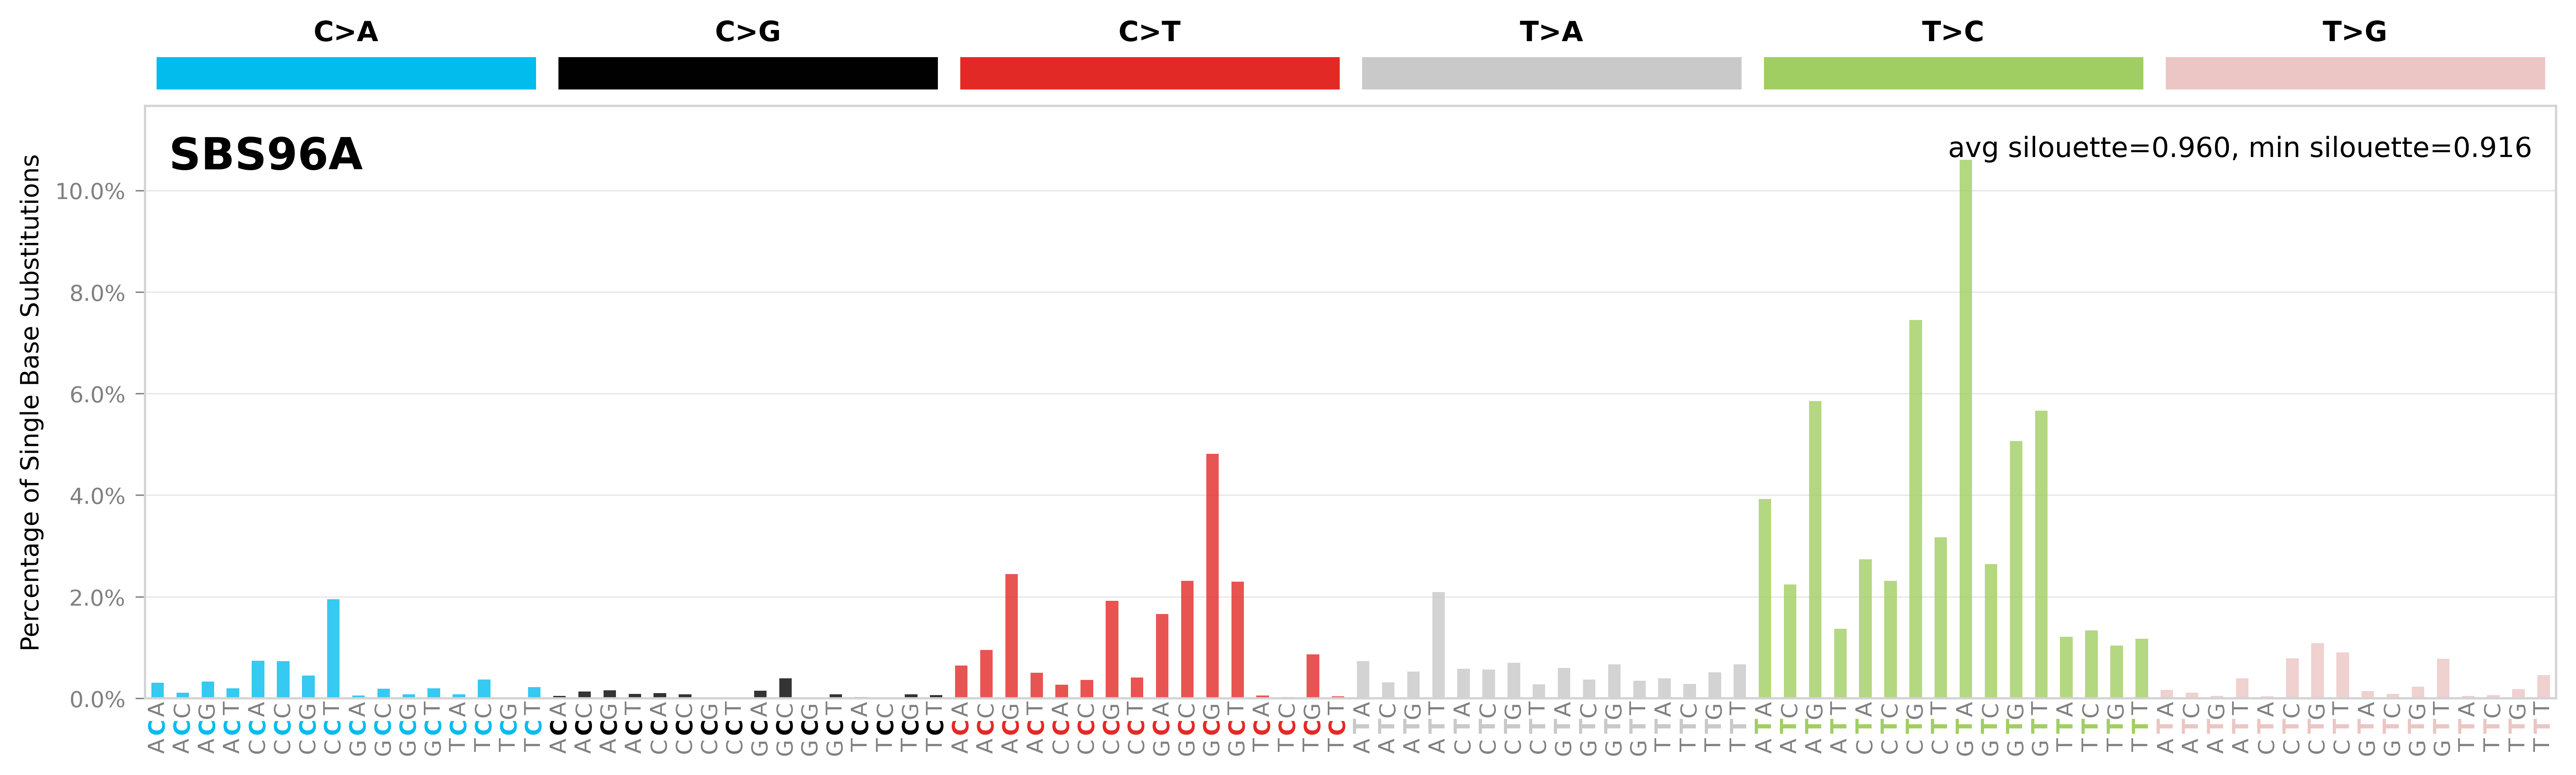

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


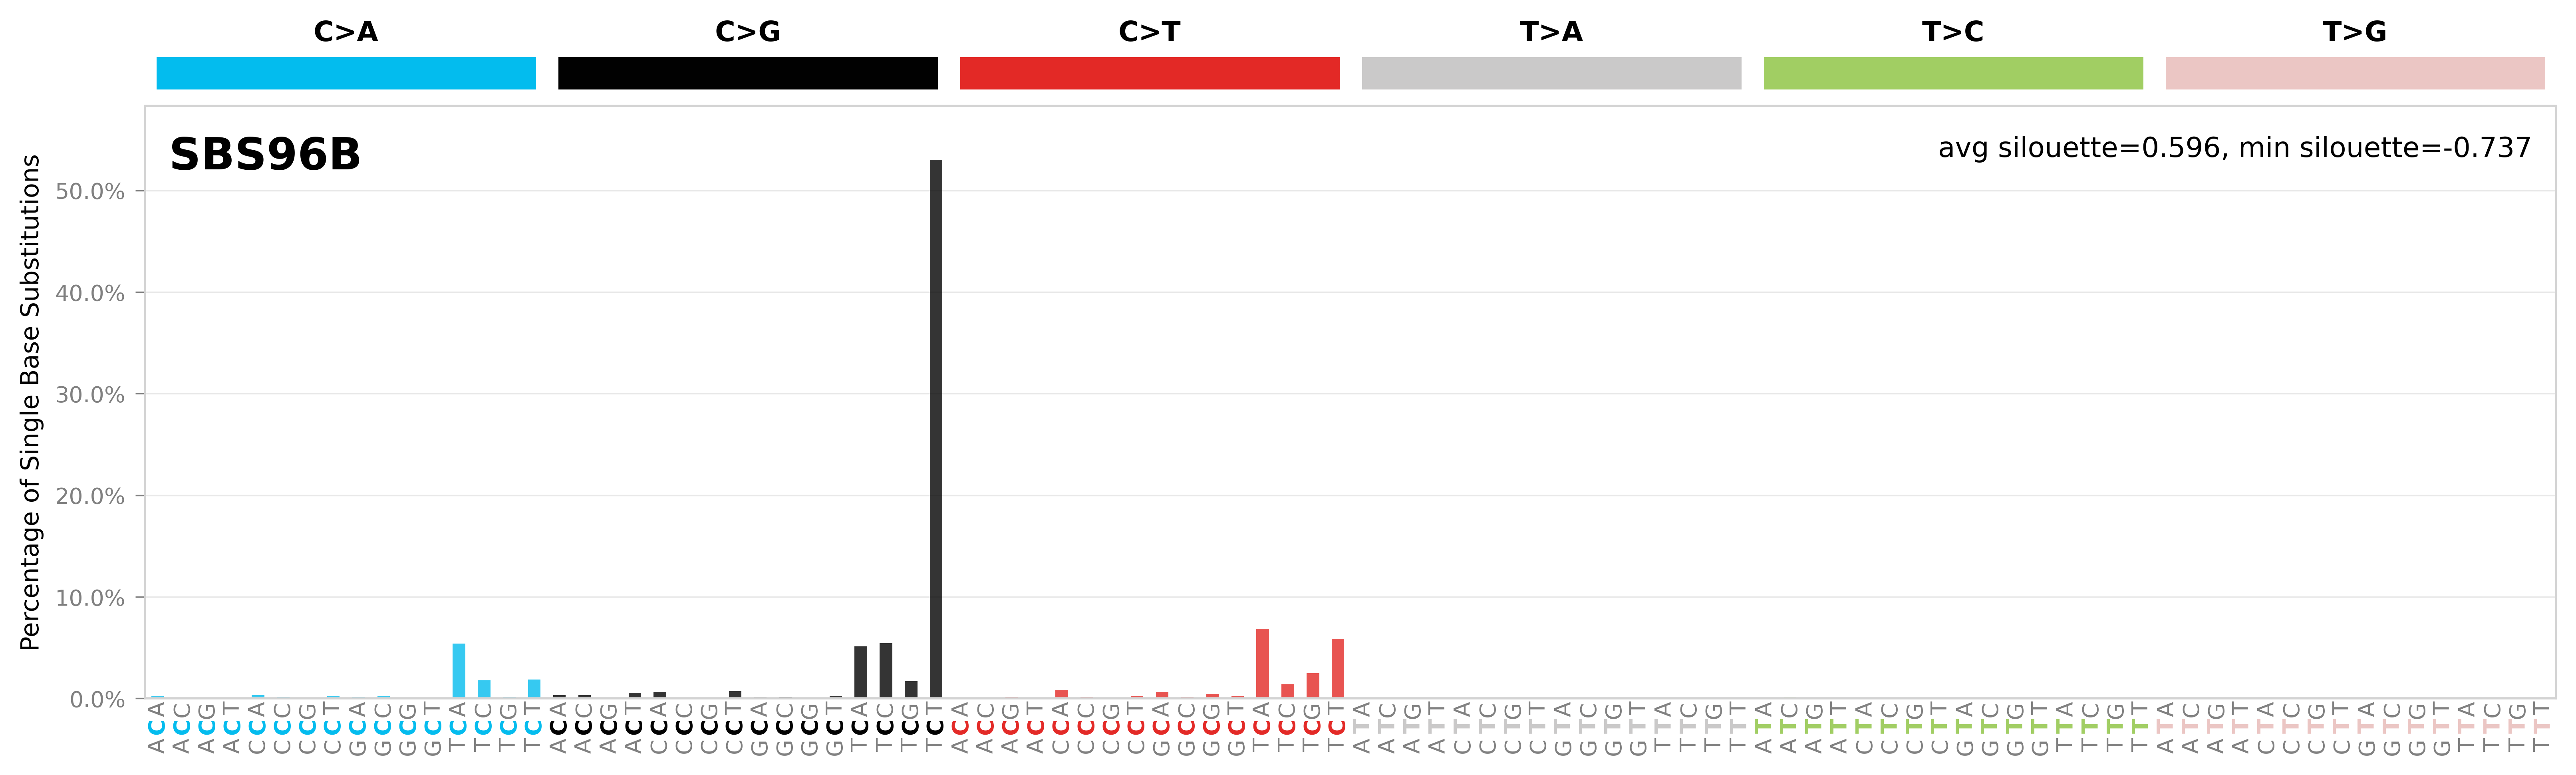

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


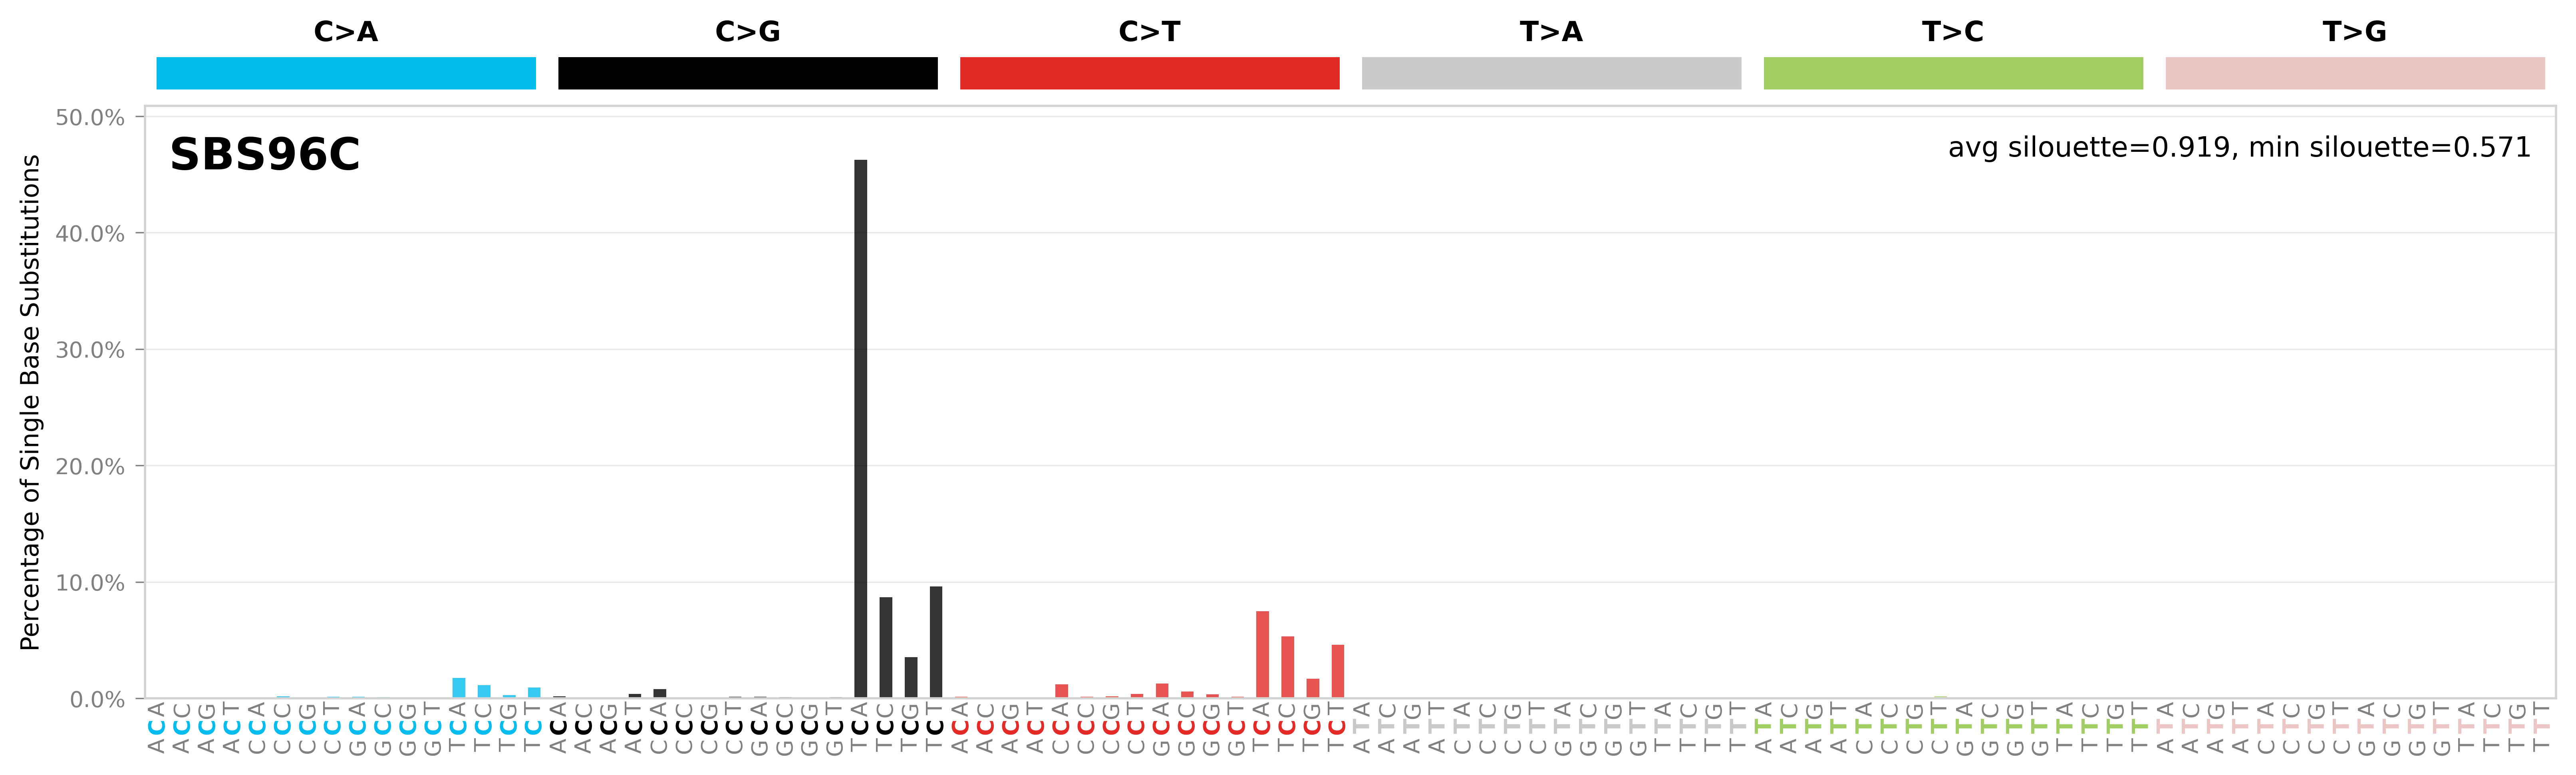

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


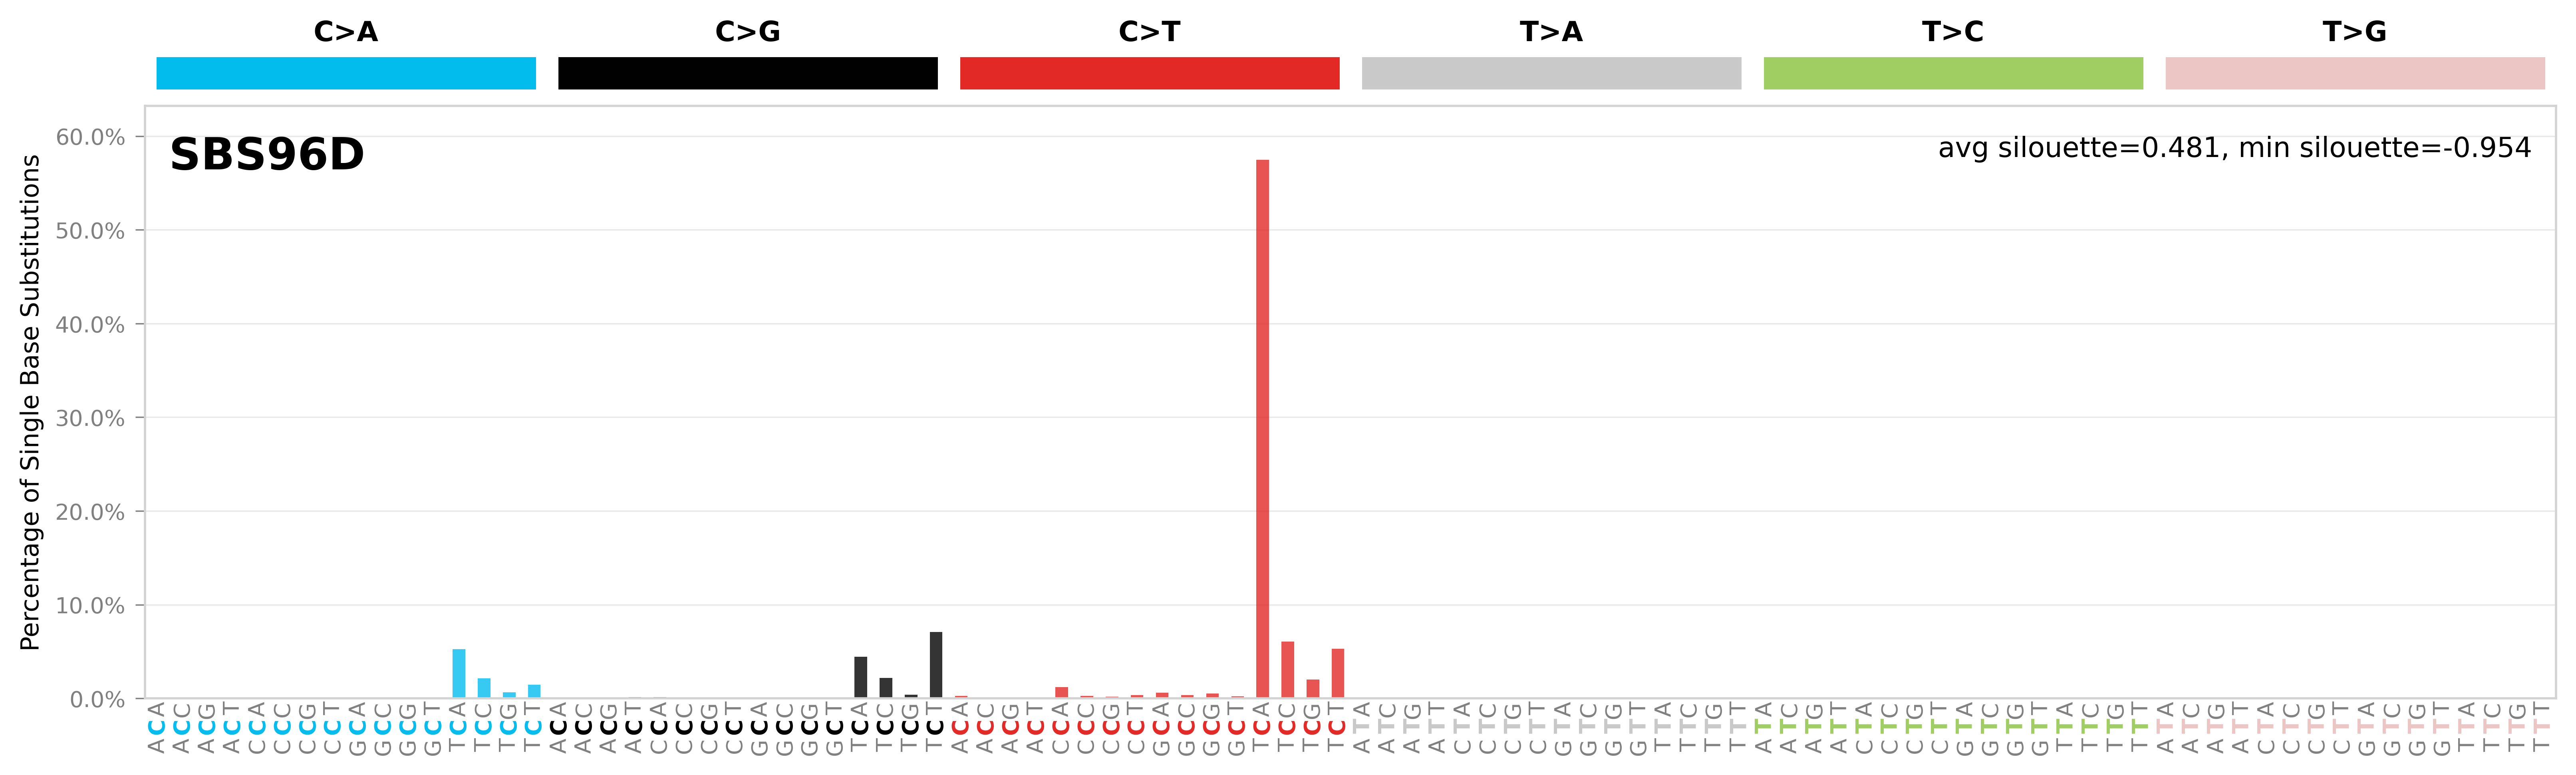

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


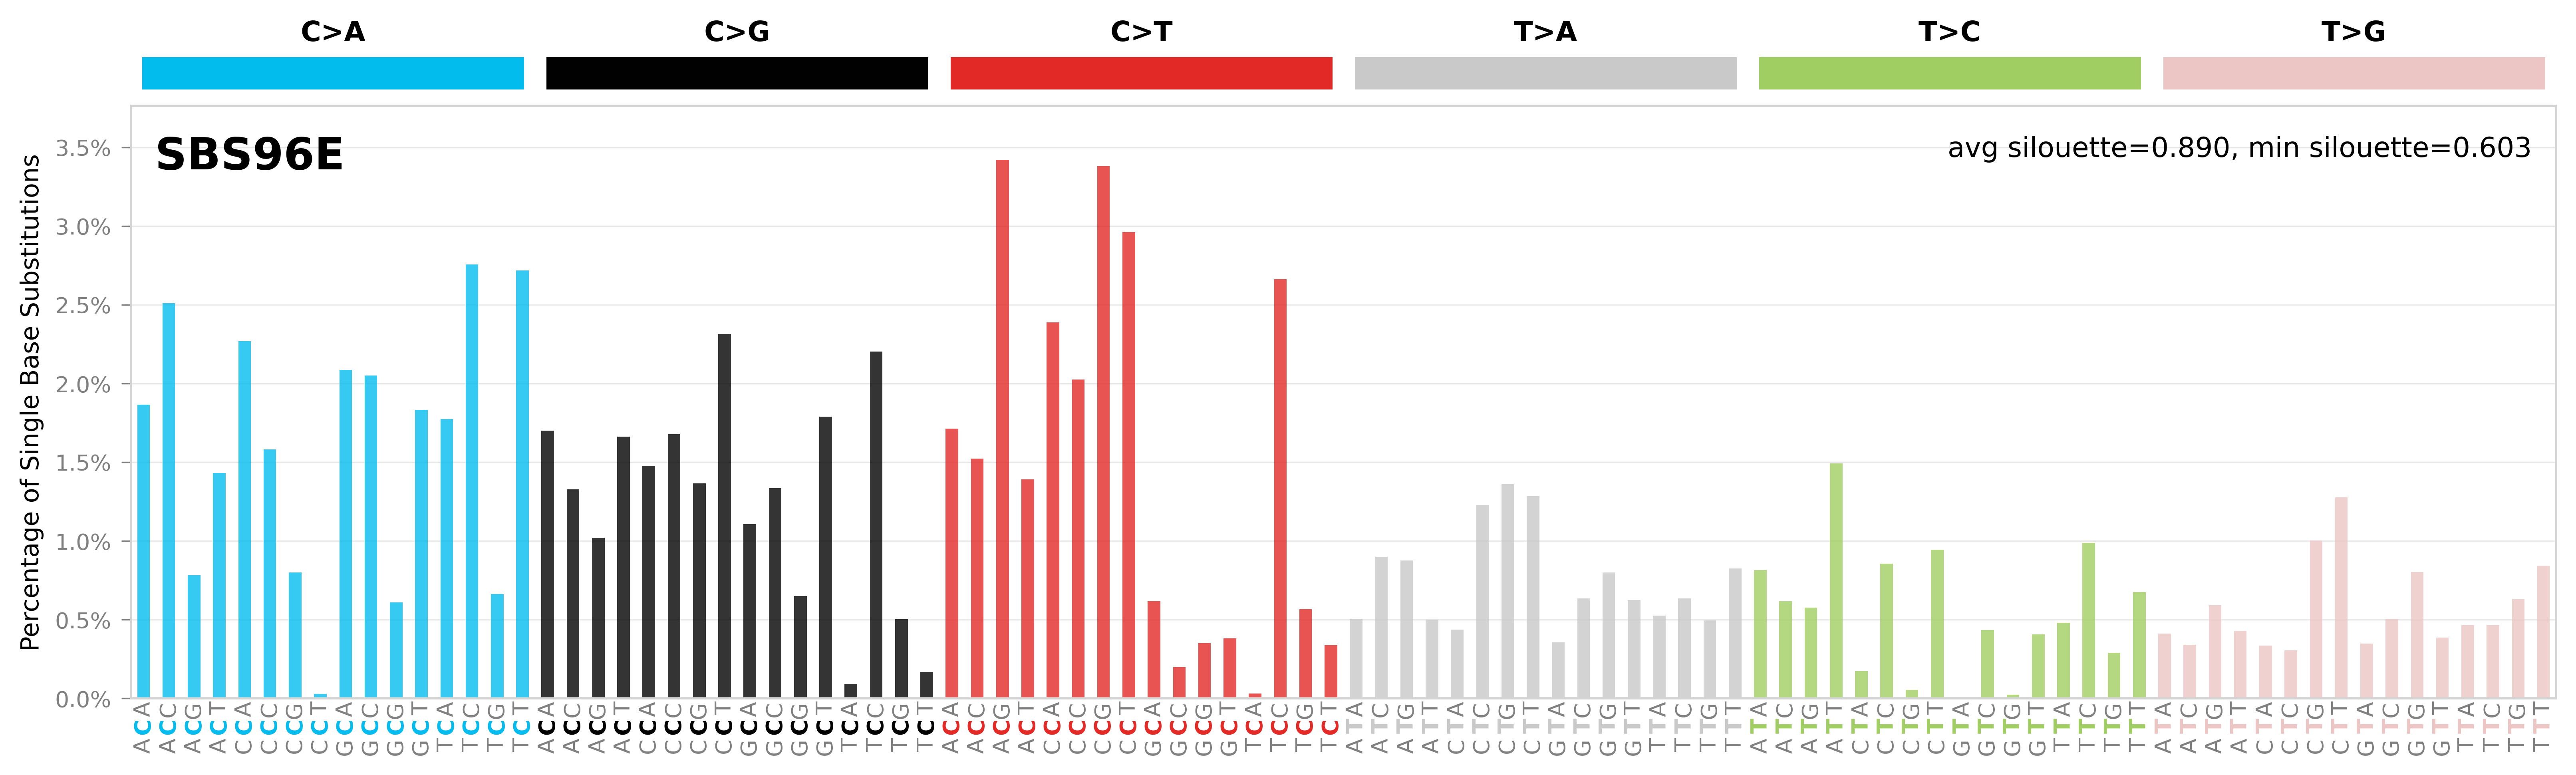

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_80742/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


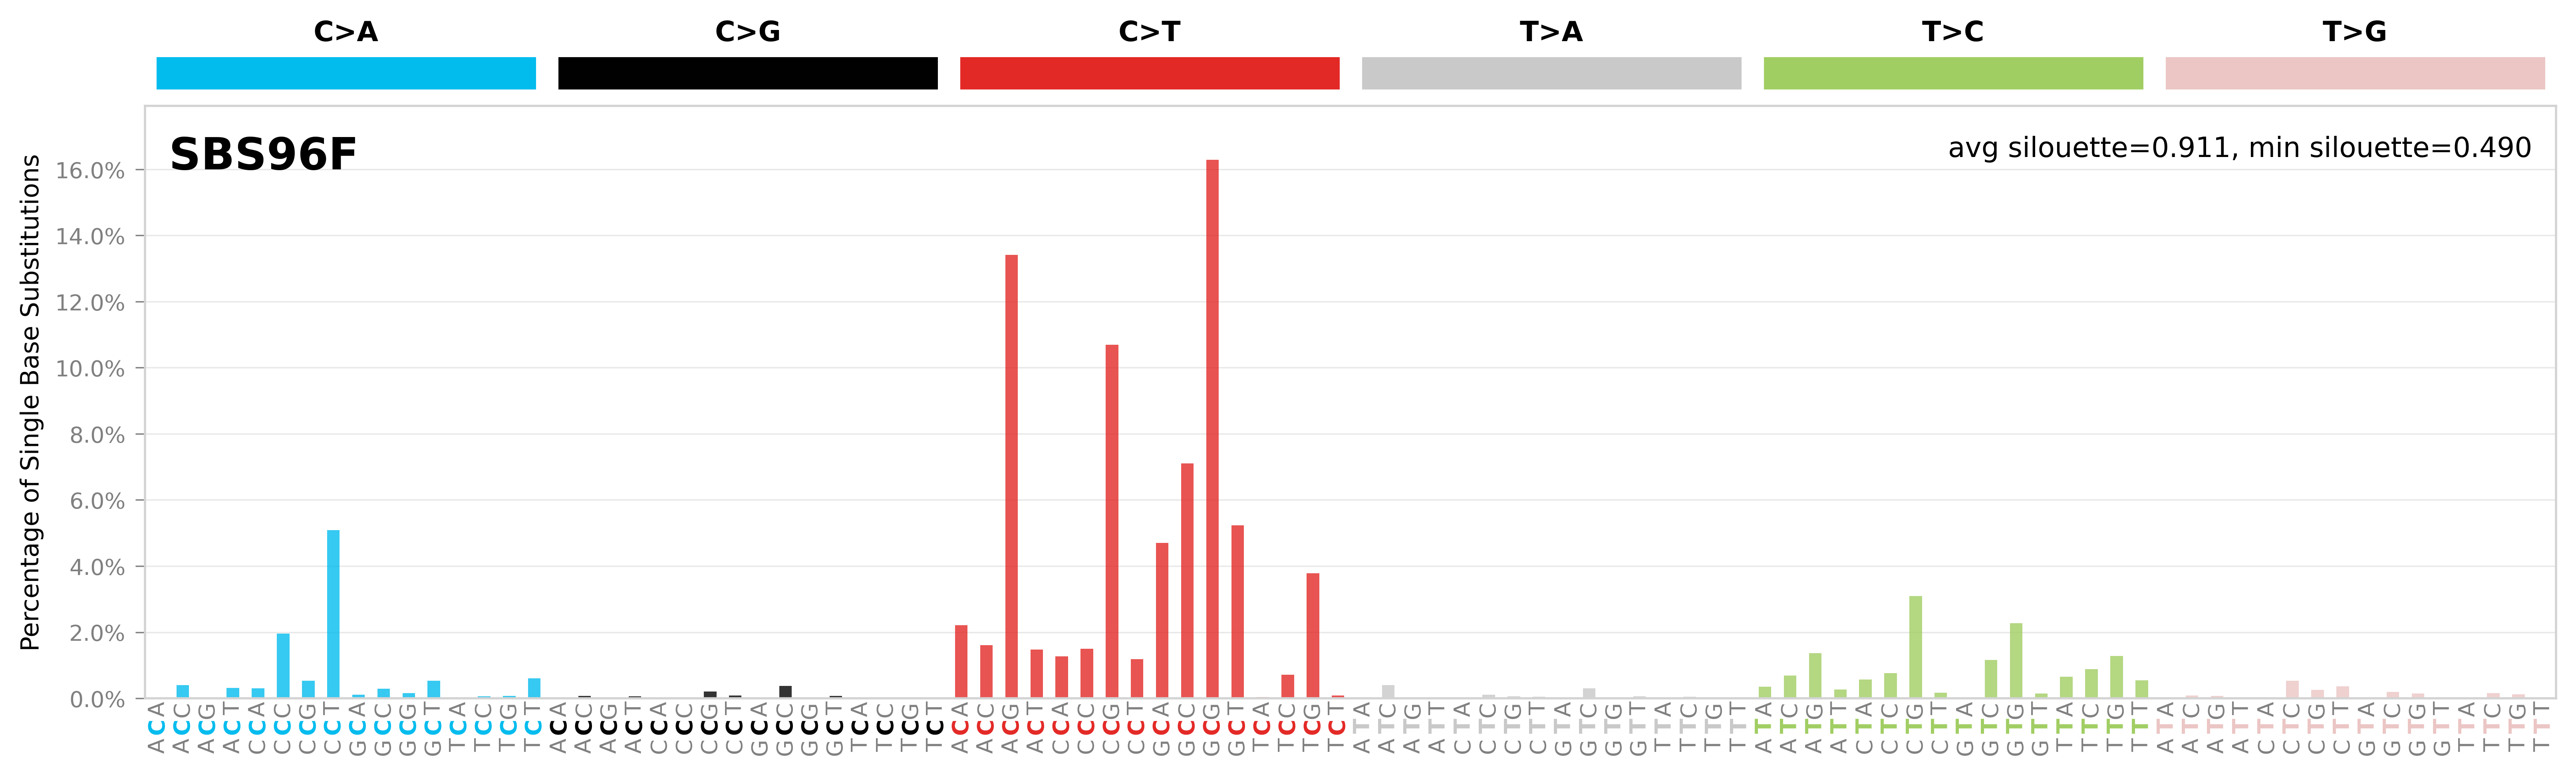

Centroid plots saved to: /Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-3/notebooks/personal/cardiff/


In [57]:
# Assuming centroids_df is your DataFrame
output_dir = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-3/notebooks/personal/cardiff/"
os.makedirs(output_dir, exist_ok=True)


# Example cluster silhouette data (replace with your actual data)
# cluster_sil_data = {
#     0: {'avg_sil': 0.965, 'min_sil': 0.890},
#     1: {'avg_sil': 0.996, 'min_sil': 0.992},
#     2: {'avg_sil': 0.973, 'min_sil': 0.899},
#     # Add more clusters as needed
# }

cluster_sil_data = {0: {'avg_sil': 0.96, 'min_sil': 0.916},
 1: {'avg_sil': 0.596, 'min_sil': -0.737},
 2: {'avg_sil': 0.919, 'min_sil': 0.571},
 3: {'avg_sil': 0.481, 'min_sil': -0.954},
 4: {'avg_sil': 0.89, 'min_sil': 0.603},
 5: {'avg_sil': 0.911, 'min_sil': 0.49},
 6: {'avg_sil': 0.905, 'min_sil': 0.42},
 7: {'avg_sil': 0.969, 'min_sil': 0.807}}

for i, column_name in enumerate(centroids_df.columns):
    output_filename = os.path.join(output_dir, f"centroid_{column_name}.png")
    plot_centroid_column(centroids_df[column_name], centroids_df.index, f"SBS96{chr(65 + i)}", output_filename, cluster_sil_data)
print(f"Centroid plots saved to: {output_dir}")
